# Collaborative Filtering for a Movie Recommendation System

### 1. Importing Libraries:

In [2]:
# Data Manipulation Libraries:
import numpy as np
import pandas as pd
# Data Vasualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns
# Data Modeling Libraries:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score


### 2. Load Data:

In [3]:
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


For the scope of our analysis we will use movies and ratings datasets only.

**Let us discover more about them.**

### 3. Preprocessing:

#### 3.1 Checking for Duplicates:

In [10]:
print(f"Number of duplicates in ratings datset: {ratings.duplicated().sum()}")

Number of duplicates in ratings datset: 0


In [11]:
# Make sure there aren't dublicates in movies dataset:
print("Number of Duplicates in movies dataset:", movies['title'].duplicated().sum())

Number of Duplicates in movies dataset: 5


Okay, We have 5 duplicated books.

**Let us take a closer look**

In [ ]:
movies[movies['title'].duplicated(keep=False)].head(10)

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


We have the same 5 movies but with different movieId. but We can't drop it simply, because the rates for this duplicated movie will lost, so we need to assign these rates for the other duplicated movie before removing them.

and because there are only 10 movies, I will make the mapping dectionary manually and I will keep movies with more genres.

In [ ]:
duplicated_ids_to_remove = [26958, 168358, 6003, 32600, 64997]
mapped_duplicated_ids = {26958:838, 168358:2851, 6003:144606, 32600:147002, 64997:34048}
print("Ratings with duplicated Ids:")
ratings.loc[ratings['movieId'].isin(duplicated_ids_to_remove)]

Ratings with duplicated Ids:


,userId,movieId,rating,timestamp
4747,28,64997,3.5,1234850075
11451,68,64997,2.5,1230497715
17449,111,6003,4.0,1516468531
23053,156,6003,3.5,1106882187
26958,182,6003,3.0,1054780821
42984,288,6003,4.0,1066059244
54020,356,6003,4.5,1229139513
59953,387,6003,3.5,1208707060
64063,414,6003,3.5,1092414917
74530,474,6003,3.5,1087831997


In [14]:
# Replace the IDs:
ratings['movieId'] = ratings['movieId'].apply(lambda x: mapped_duplicated_ids[x] if x in duplicated_ids_to_remove else x)

In [15]:
print("Ratings with duplicated Ids:")
ratings.loc[ratings['movieId'].isin(duplicated_ids_to_remove)]

Ratings with duplicated Ids:


,userId,movieId,rating,timestamp


The duplicated ids replaced successfully, let us remove them from movies dataset.

In [16]:
movies = movies[~movies['movieId'].isin(duplicated_ids_to_remove)]
print('Number of Duplicated movies titles:',movies['title'].duplicated().sum())

Number of Duplicated movies titles: 0


Duplicated Rows removed successfully.

#### 3.2 Checking for Missing data:

In [17]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [18]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

No missing data.

#### 3.3 Checking for outliers:

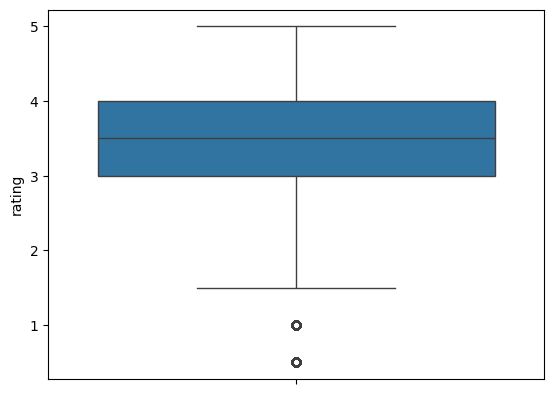

In [19]:
sns.boxplot(ratings['rating'])
plt.show()

In [20]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

After searching for MovieLens website, The rating system from 0.5 star to 5 stars, So our values is ok.

### 4. EDA:

#### 4.1 Discover the distrbution of ratings:

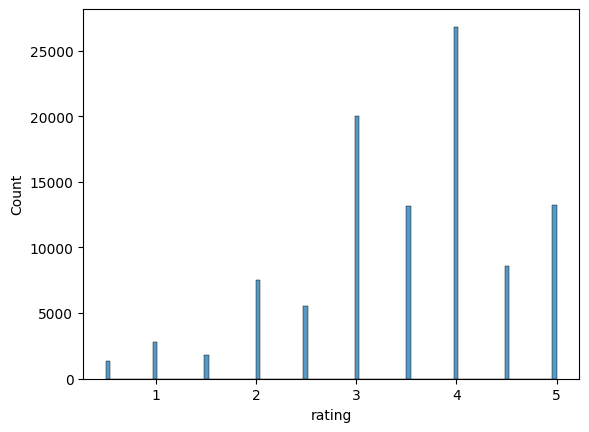

In [21]:
sns.histplot(ratings['rating'])
plt.show()

The most rating is 4 starts, and our users perfer to rate by whole number more than fractions.

#### 4.2 Discover how often the user rates movies:

In [22]:
print("Number of Unique Users:", ratings['userId'].nunique())

Number of Unique Users: 610


In [23]:
users_rating_number = ratings.groupby(by='userId')['movieId'].count().reset_index().rename(columns={'movieId':'number of ratings'})
users_rating_number.head()

,userId,number of ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [24]:
print("The summary statistcs for number of ratings:")
users_rating_number['number of ratings'].describe()

The summary statistcs for number of ratings:


count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: number of ratings, dtype: float64

Our users are active, the min user have rated 20 movies, and in median the users rates about 70 movie, But we have very big numbers of ratings (2698).

**Let Us take a closer look**

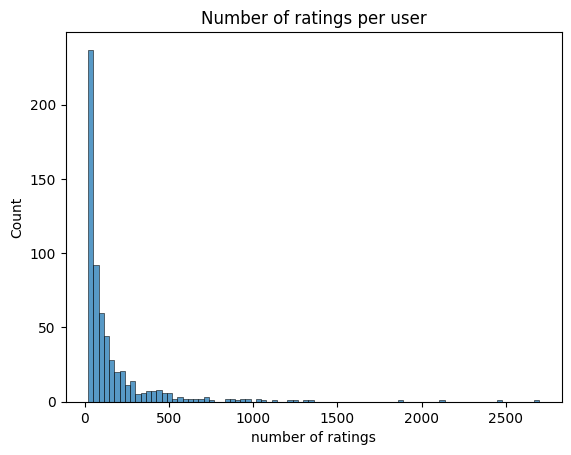

In [25]:
sns.histplot(users_rating_number['number of ratings'])
plt.title("Number of ratings per user")
plt.show()

Okay we have a very active users, they have rated more than 1000 movie :o

#### 4.3 Discover how often the movie rated by users:

In [26]:
print("Number of Unique Movies had rated:", ratings['movieId'].nunique())

Number of Unique Movies had rated: 9719


In [27]:
movies_rating_number = ratings.groupby(by='movieId')['userId'].count().reset_index().rename(columns={'userId':'number of ratings'})
movies_rating_number.head()

,movieId,number of ratings
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [28]:
print("The summary statistcs for number of ratings:")
movies_rating_number['number of ratings'].describe()

The summary statistcs for number of ratings:


count    9719.000000
mean       10.375141
std        22.406220
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: number of ratings, dtype: float64

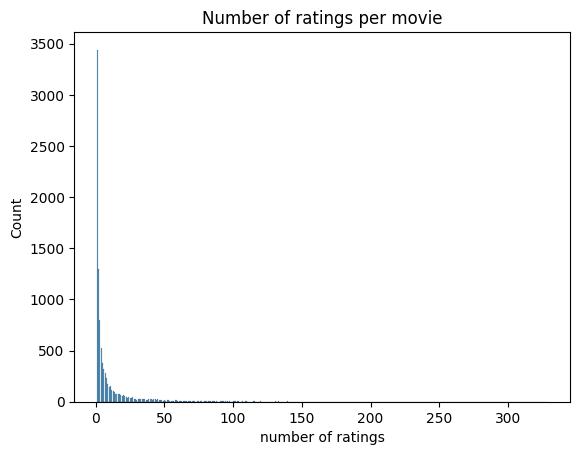

In [29]:
sns.histplot(movies_rating_number['number of ratings'])
plt.title("Number of ratings per movie")
plt.show()

Hmmmm, As expected there are a lot of movies have only 1 rating, about 25% percent of our movies have 1 rating, and about 50% percent of movies have equal or less than 3 ratings and That can be a problem for our analysis.

**but there are movies have a lot of ratings let us take a closer look for these popular movies**

In [30]:
top_20_movies_ids = movies_rating_number.sort_values(by='number of ratings', ascending=False).head(20)['movieId']
movies[movies['movieId'].isin(top_20_movies_ids)].head(20)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


I think these movies not here by mistake, I have watched about 17 movie from these movies.

### 5. Preparation the data for our recommendation systems:

#### 5.1 Join movies with ratings:

In [31]:
# Merging movie and rating data sets
df = movies.merge(ratings, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


#### 5.2 Train test split:

Okay, In our case the train test split isn't a simple thing,
because the ratings for every user have a timestemp, So we need to make into the consideration the chronological order for every user rating.

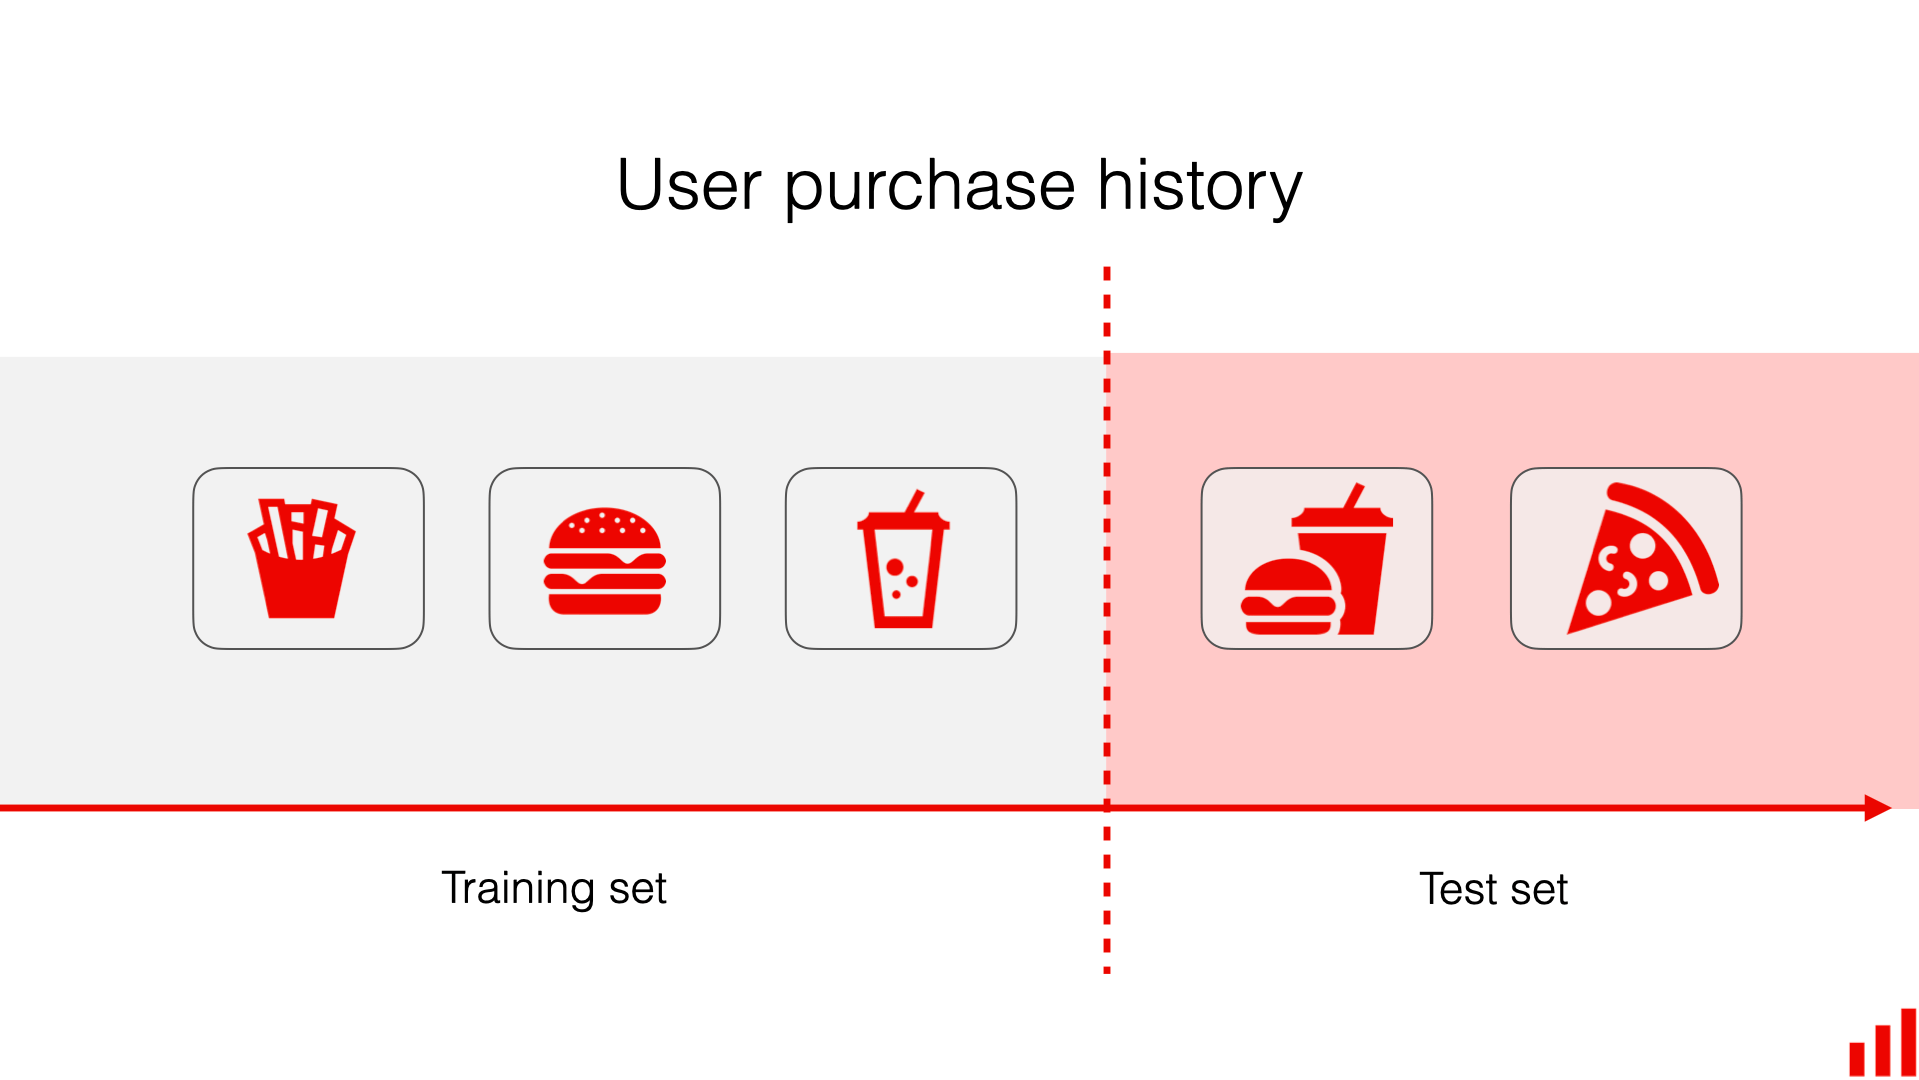

Like the image above, if we split the data to 80:20 perecnt for training and testing dataset.
we need to make that with respect for every user and with respect for the order of watching.
e.g.:
If we have user had watched 20 movies, so we will split the 4 recent rated movies as test data and the oldest 16 rated movie to train on them.

In [32]:
def custom_train_test_split(df, test_ratio=0.2):
    unique_users = df['userId'].unique()
    train_ratings = []
    test_ratings = []

    for user in unique_users:
        user_ratings = df[df['userId'] == user].sort_values(by='timestamp')
        total_ratings = len(user_ratings)
        test_count = int(np.floor(test_ratio*total_ratings))
        train_count = total_ratings - test_count

        if test_count>=1:
            train_ratings.append(user_ratings.iloc[:train_count])
            test_ratings.append(user_ratings.iloc[train_count:])

    # Combine all train and test sets
    train_df = pd.concat(train_ratings)
    test_df = pd.concat(test_ratings)
    
    # Return the train and test DataFrames
    return train_df, test_df
        

train, test = custom_train_test_split(df)
print("is the split successed?", train.shape[0] + test.shape[0] == ratings.shape[0])

is the split successed? True


In [33]:
# We should have the same number of users in the train and test and orignal dataset:
print(df['userId'].nunique())
print(df['userId'].nunique())
print(df['userId'].nunique())

610
610
610


In [34]:
print('Number of Movies in Original data set:',df['movieId'].nunique())
print('Number of Movies in Training data set:', train['movieId'].nunique())
print('Number of Movies in Testing data set:', test['movieId'].nunique())

Number of Movies in Original data set: 9737
Number of Movies in Training data set: 8245
Number of Movies in Testing data set: 6242


In [35]:
print('Number of Movies in test data and not in train data:')
print(len(set(test['movieId'].unique()) - set(train['movieId'].unique())))

Number of Movies in test data and not in train data:
1474


Some movies in the test set were not present in the train set. This can happen because the splitting logic is user-centric, and not all users have rated the same movies. As a result, there may be movies in the test set that no user in the train set rated.

##### Why This Is a Problem?
For a collaborative filtering model, any movie in the test set that is not in the train set cannot be predicted, as the model relies on historical ratings in the train set. This leads to evaluation errors or inaccurate results.

##### Solution: Filter Out Movies in the Test Set Not Present in the Train Set

In [36]:
# Filter the test set to include only movies present in the train set
filtered_test = test[test['movieId'].isin(train['movieId'].unique())]

# Verify the updated test set
print("Number of unique movies in ratings:", ratings['movieId'].nunique())
print("Number of unique movies in train set:", train['movieId'].nunique())
print("Number of unique movies in filtered test set:", filtered_test['movieId'].nunique())
print("Movies in the original test set not in train set:", len(set(test['movieId'].unique()) - set(train['movieId'].unique())))
print("Movies in the filtered test set not in train set:", len(set(filtered_test['movieId'].unique()) - set(train['movieId'].unique())))


Number of unique movies in ratings: 9719
Number of unique movies in train set: 8245
Number of unique movies in filtered test set: 4768
Movies in the original test set not in train set: 1474
Movies in the filtered test set not in train set: 0


#### 5.3 Make user_movie matrix:

In [37]:
# Create user-movie matrix
user_movie_matrix = train.pivot_table(index='userId', columns='title', values='rating')
user_movie_matrix.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here is our beautiful sparse dataset.

In [38]:
# Fill missing values with 0.
user_movie_matrix = user_movie_matrix.fillna(0)

In [39]:
user_movie_matrix.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 5.4 Calculate user similarity and item similarity based on the interactions on our train data:

In [40]:
# Compute cosine similarity
user_similarity = cosine_similarity(user_movie_matrix)

In [41]:
user_similarity.shape

(610, 610)

In [42]:
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Display the first 5 rows of the similarity matrix
user_similarity_df.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.034123,0.062759,0.170851,0.142020,0.107125,0.145436,0.116805,0.045134,0.020689,...,0.058068,0.127225,0.208391,0.054297,0.135443,0.131656,0.176777,0.282887,0.116314,0.112031
2.0,0.034123,1.000000,0.000000,0.000000,0.020661,0.031275,0.028115,0.033740,0.000000,0.082738,...,0.198635,0.020601,0.008051,0.000000,0.000000,0.019353,0.015939,0.019735,0.034286,0.108517
3.0,0.062759,0.000000,1.000000,0.002473,0.000000,0.003047,0.000000,0.000000,0.000000,0.000000,...,0.002477,0.002007,0.025741,0.000000,0.011621,0.011647,0.017084,0.021483,0.000000,0.024963
4.0,0.170851,0.000000,0.002473,1.000000,0.111219,0.088288,0.122046,0.048053,0.012995,0.030122,...,0.049224,0.089589,0.296571,0.058345,0.076479,0.187605,0.103367,0.120456,0.026159,0.063168
5.0,0.142020,0.020661,0.000000,0.111219,1.000000,0.331440,0.129899,0.508350,0.000000,0.037313,...,0.065795,0.382643,0.115021,0.262439,0.179301,0.099178,0.152154,0.146825,0.322862,0.074561


### 6. Build User-based collaborative filtering:

#### 6.1 Dev Function:
this implementation for this function is missy because I am trying to evaluate the logic of my function you will get the cleaner version below.

In [43]:
# Function to generate recommendations
def recommend_movies_dev(user_id, user_movie_matrix, user_similarity_df, top_n=5):
    # Get the top n similer users based on similarity scores for the target user
    similar_users = user_similarity_df.loc[user_id,:].sort_values(ascending=False).iloc[1:top_n+1]
    # similar_users = user_similarity_df.loc[user_id,:].sort_values(ascending=False).iloc[1:]
    print('similar users', similar_users.index)

    # Get movies rated by similar users
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]
    display('movies rated by similar users ', user_movie_matrix.loc[similar_users.index])

    # Get all the movies rated (i.e., ratings > 0) by at least one of the top 5 similar users
    rated_movies = similar_users_ratings.columns[(similar_users_ratings > 0).any(axis=0)]

    display('movies rated by at least one of the top 5 similar users', similar_users_ratings.loc[:,rated_movies])
    user_ratings = user_movie_matrix.loc[user_id,:]
    unseen_movies = user_ratings[user_ratings == 0].index
    unseen_movies_seen_by_similer = unseen_movies[unseen_movies.isin(rated_movies)]
    print("Number of unseen movies", len(unseen_movies))
    print("Number of unseen movies and seened by at least one similer user", len(unseen_movies[unseen_movies.isin(rated_movies)]))

    # Weighted average of ratings by similar users
    weighted_ratings = pd.Series(0, index=unseen_movies_seen_by_similer)
    display('w r before', weighted_ratings)
    for similar_user, similarity in similar_users.items():
        weighted_ratings += user_movie_matrix.loc[similar_user, unseen_movies_seen_by_similer] * similarity

    # Normalize the weighted ratings
    print("similer user sum", weighted_ratings)
    print('Helllo Number of similer users rated the movies', (similar_users_ratings.loc[:,unseen_movies_seen_by_similer].values > 0).sum(axis=0))
    print('Helllo Number of similer users rated the movies', (similar_users_ratings.loc[:,unseen_movies_seen_by_similer].values > 0).astype(int))
    # display('hello', similar_users_ratings.loc[:,unseen_movies_seen_by_similer], similar_users.values, similar_users_ratings.loc[:,unseen_movies_seen_by_similer] * similar_users.values.reshape(5,1))
    unnamed = (similar_users_ratings.loc[:,unseen_movies_seen_by_similer].values > 0).astype(int) * similar_users.values.reshape(5,1)
    display('unnnamed', unnamed.sum(axis=0))
    weighted_ratings /= unnamed.sum(axis=0)
    top_ratings = weighted_ratings.sort_values(ascending=False)
    # Sort and return top recommendations
    recommendations = pd.DataFrame({
        'movie_title': top_ratings.index,
        'expected_rating': top_ratings.values
    })

    return recommendations
recommendations = recommend_movies_dev(1, user_movie_matrix, user_similarity_df, 5)
print("Top 10 Movies for User 1:")
recommendations.head()

similar users Index([217.0, 577.0, 288.0, 45.0, 57.0], dtype='float64', name='userId')


'movies rated by similar users '

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
217.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


'movies rated by at least one of the top 5 similar users'

title,"'burbs, The (1989)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),1984 (Nineteen Eighty-Four) (1984),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",200 Cigarettes (1999),2001: A Space Odyssey (1968),2010: The Year We Make Contact (1984),...,Yellow Submarine (1968),Yojimbo (1961),You Can't Take It with You (1938),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Zoolander (2001),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
217.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,0.0,0.0,4.0,0.0,0.0
577.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288.0,3.0,3.0,3.0,0.0,2.0,0.0,3.0,0.0,5.0,3.0,...,3.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,3.0,0.0
45.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,...,0.0,5.0,0.0,0.0,4.0,3.0,2.0,0.0,0.0,2.0


Number of unseen movies 8059
Number of unseen movies and seened by at least one similer user 1145


'w r before'

title
'burbs, The (1989)                                        0
101 Dalmatians (1996)                                     0
101 Dalmatians (One Hundred and One Dalmatians) (1961)    0
12 Angry Men (1957)                                       0
1984 (Nineteen Eighty-Four) (1984)                        0
                                                         ..
Young Frankenstein (1974)                                 0
Young Guns (1988)                                         0
Young Guns II (1990)                                      0
Zoolander (2001)                                          0
¡Three Amigos! (1986)                                     0
Length: 1145, dtype: int64

similer user sum title
'burbs, The (1989)                                        0.982245
101 Dalmatians (1996)                                     1.953140
101 Dalmatians (One Hundred and One Dalmatians) (1961)    1.975334
12 Angry Men (1957)                                       1.319144
1984 (Nineteen Eighty-Four) (1984)                        1.644188
                                                            ...   
Young Frankenstein (1974)                                 3.584159
Young Guns (1988)                                         0.961057
Young Guns II (1990)                                      0.640705
Zoolander (2001)                                          0.982245
¡Three Amigos! (1986)                                     0.640705
Length: 1145, dtype: float64
Helllo Number of similer users rated the movies [1 2 2 ... 1 1 1]
Helllo Number of similer users rated the movies [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]]


'unnnamed'

array([0.32741508, 0.65104678, 0.65844457, ..., 0.32035247, 0.32741508,
       0.32035247], shape=(1145,))

Top 10 Movies for User 1:


,movie_title,expected_rating
0,Victor/Victoria (1982),5.0
1,"Lord of the Rings: The Fellowship of the Ring,...",5.0
2,"Third Man, The (1949)",5.0
3,American Pie 2 (2001),5.0
4,Lifeboat (1944),5.0


#### 6.2 Cleaner Version of Recommender:

In [44]:
# Function to generate recommendations
def recommend_movies(user_id, user_movie_matrix, user_similarity_df, top_n=5):
    # Get the top n similer users based on similarity scores for the target user
    similar_users = user_similarity_df.loc[user_id,:].sort_values(ascending=False).iloc[1:top_n+1]

    # Get movies rated by similar users
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]

    # Get all the movies rated (i.e., ratings > 0) by at least one of the top 5 similar users
    rated_movies = similar_users_ratings.columns[(similar_users_ratings > 0).any(axis=0)]

    user_ratings = user_movie_matrix.loc[user_id,:]
    unseen_movies = user_ratings[user_ratings == 0].index
    unseen_movies_seen_by_similer = unseen_movies[unseen_movies.isin(rated_movies)]

    # Weighted average of ratings by similar users
    weighted_ratings = pd.Series(0, index=unseen_movies_seen_by_similer)
    for similar_user, similarity in similar_users.items():
        weighted_ratings += user_movie_matrix.loc[similar_user, unseen_movies_seen_by_similer] * similarity

    # Normalize the weighted ratings
    unnamed = (similar_users_ratings.loc[:,unseen_movies_seen_by_similer].values > 0).astype(int) * similar_users.values.reshape(top_n,1)
    weighted_ratings /= unnamed.sum(axis=0)
    top_ratings = weighted_ratings.sort_values(ascending=False)
    # Sort and return top recommendations
    recommendations = pd.DataFrame({
        'title': top_ratings.index,
        'expected_rating': top_ratings.values
    })

    return recommendations
recommendations = recommend_movies(1, user_movie_matrix, user_similarity_df, 5)
print(len(recommendations))
recommendations.head(10)

1145


,title,expected_rating
0,Victor/Victoria (1982),5.0
1,"Lord of the Rings: The Fellowship of the Ring,...",5.0
2,"Third Man, The (1949)",5.0
3,American Pie 2 (2001),5.0
4,Lifeboat (1944),5.0
5,Little Big Man (1970),5.0
6,"Maltese Falcon, The (1941)",5.0
7,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",5.0
8,"Last Detail, The (1973)",5.0
9,Lawrence of Arabia (1962),5.0


In [45]:
test[test['userId'] == 1].head()

,movieId,title,genres,userId,rating,timestamp
30188,1348,"Nosferatu (Nosferatu, eine Symphonie des Graue...",Horror,1.0,4.0,964983393.0
26460,1219,Psycho (1960),Crime|Horror,1.0,2.0,964983393.0
46134,2654,"Wolf Man, The (1941)",Drama|Fantasy|Horror,1.0,5.0,964983393.0
46112,2644,Dracula (1931),Horror,1.0,4.0,964983393.0
28971,1278,Young Frankenstein (1974),Comedy|Fantasy,1.0,5.0,964983414.0


In [46]:
recommendation4user1 = recommend_movies(1, user_movie_matrix, user_similarity_df, 5)
recommendation4user1.head()

,title,expected_rating
0,Victor/Victoria (1982),5.0
1,"Lord of the Rings: The Fellowship of the Ring,...",5.0
2,"Third Man, The (1949)",5.0
3,American Pie 2 (2001),5.0
4,Lifeboat (1944),5.0


In [47]:
recommendation4user1 = pd.merge(recommendation4user1, test[test['userId'] == 1][['title', 'rating']], on='title', how='inner')
recommendation4user1.head()

,title,expected_rating,rating
0,Psycho (1960),5.000000,2.0
1,Schindler's List (1993),5.000000,5.0
2,"Silence of the Lambs, The (1991)",4.497829,4.0
3,Back to the Future (1985),4.249256,5.0
4,20 Dates (1998),4.000000,4.0


In [48]:
print('MAE for first user:', mean_absolute_error(recommendation4user1['rating'], recommendation4user1['expected_rating']))
print('RMSE for first user:', np.sqrt(mean_squared_error(recommendation4user1['rating'], recommendation4user1['expected_rating'])))

MAE for first user: 1.3342364039246408
RMSE for first user: 1.5885988544953054


In [49]:
all_recommendations = []
for user_id in ratings['userId'].unique():
    recommendations = recommend_movies(user_id, user_movie_matrix, user_similarity_df, 5)
    recommendations_ = pd.merge(recommendations, filtered_test[filtered_test['userId'] == user_id][['title', 'rating']], on='title', how='inner')
    all_recommendations.append(recommendations_)

all_recommendations = pd.concat(all_recommendations)

print(f"MAE {mean_absolute_error(all_recommendations['rating'], all_recommendations['expected_rating'])}")
print(f"RMSE {np.sqrt(mean_squared_error(all_recommendations['rating'], all_recommendations['expected_rating']))}")

MAE 0.8495410885674505
RMSE 1.1177321500615849


In [50]:

# Generate recommendations for test users
def evaluate_recommendations(test, train_matrix, user_similarity_df, top_n=5):

    all_recommendations, precisions, recalls = [], [], []

    for user_id in test['userId']:
        # Skip users not in training data
        if user_id not in train_matrix.index:
            continue

        # Generate recommendations
        recommendations = recommend_movies(user_id, train_matrix, user_similarity_df, top_n)
        recommendations_with_actual_ratings = pd.merge(recommendations[['title', 'expected_rating']], filtered_test[filtered_test['userId'] == user_id][['title', 'rating']], on='title', how='inner')
        all_recommendations.append(recommendations_with_actual_ratings)

        relevant_recommended_movies = recommendations[recommendations['expected_rating']>=4]
        relvant_actual_movies = filtered_test[(filtered_test['userId'] == user_id) & (filtered_test['rating'] >= 4)]

        # Calculate precision and recall
        true_positives = len(set(relevant_recommended_movies.title) & set(relvant_actual_movies.title))
        precisions.append(true_positives / len(relevant_recommended_movies) if len(relevant_recommended_movies) else 0)
        recalls.append(true_positives / len(relvant_actual_movies) if len(relvant_actual_movies) else 0)

    all_recommendations = pd.concat(all_recommendations)
    # MAE and RMSE
    MAE = mean_absolute_error(all_recommendations['rating'], all_recommendations['expected_rating'])
    RMSE = np.sqrt(mean_squared_error(all_recommendations['rating'], all_recommendations['expected_rating']))
    # Average precision and recall
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    return MAE, RMSE, avg_precision, avg_recall

# Evaluate
MAE, RMSE, precision, recall = evaluate_recommendations(test, user_movie_matrix, user_similarity_df)
print(f"Mean Absolute Error: {MAE} RMSE: {RMSE}\nPrecision: {precision:.4f}, Recall: {recall:.4f}")


Mean Absolute Error: 0.8255654851880161 RMSE: 1.069941110245413
Precision: 0.0298, Recall: 0.2663


In [51]:
# Compute Pearson correlation for item-item similarity
item_item_matrix = user_movie_matrix.T
item_similarity = item_item_matrix.corr(method='pearson')

In [52]:
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)
item_similarity_df.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
item_similarity_df = item_similarity_df.fillna(0)

In [54]:
item_similarity_df.head()

title,'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Visualize item similarity as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(item_similarity_df, cmap='coolwarm', square=True)
plt.title('Item-Item Similarity Heatmap')
plt.savefig('item_similarity_heatmap.pdf')
plt.show()
